In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil

import warnings
warnings.filterwarnings(action="ignore")

## bicycle 대여 데이터 전처리

In [2]:
# import dask.dataframe as dd
# bicycle=dd.read_csv('서울시따릉이대여소별대여반납승객수(22년1월~22년9월).csv',encoding='cp949')

In [3]:
bicycle=pd.read_csv('서울시따릉이대여소별대여반납승객수(22년1월~22년9월).csv',header=None,encoding='cp949')
bicycle.columns=['기준_날짜', '기준_집계', '기준_시간대', '시작_대여소_ID', '시작_대여소명', '종료_대여소_ID', '종료_대여소명', '전체_건수', '전체_이용_분', '전체_이용_거리']
bicycle

,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20220101,0,0,ST-2280,이문1동_052_1,ST-401,이문1동_056_1,1,2,410.00
1,20220101,0,0,ST-2738,둔촌2동_002_1,ST-1720,오륜동_001_5,1,16,0.00
2,20220101,0,0,ST-99,자양3동_050_1,ST-99,자양3동_050_1,1,67,0.00
3,20220101,0,0,ST-262,장안2동_053_1,ST-242,용답동_004_2,1,8,1714.24
4,20220101,0,0,ST-1812,창신1동_008_1,ST-1812,창신1동_008_1,1,99,4560.14
...,...,...,...,...,...,...,...,...,...,...
58635461,20220930,1,2355,ST-285,문래동_057_1,ST-1968,영등포동_006_1,1,21,2040.00
58635462,20220930,1,2355,ST-819,도곡2동_004_1,ST-810,역삼1동_053_2,1,14,1463.74
58635463,20220930,1,2355,ST-50,여의동_034_1,ST-72,여의동_005_14,1,12,1594.27
58635464,20220930,1,2355,ST-637,독산1동_018_1,ST-2892,구로5동_053_1,1,28,4361.01


### 중복 데이터 수정 

In [4]:
# 예시 ) 같은 이동인데 출발시간 기준 집계(기준_집계:0) & 도착시간 기준 집계(기준_집계:1)
bicycle[(bicycle['기준_날짜']==20220930) & (bicycle['시작_대여소_ID']=='ST-285') & (bicycle['종료_대여소_ID']=='ST-1968')]

,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
58631891,20220930,0,2335,ST-285,문래동_057_1,ST-1968,영등포동_006_1,1,21,2040.0
58635461,20220930,1,2355,ST-285,문래동_057_1,ST-1968,영등포동_006_1,1,21,2040.0


In [5]:
# 이론상으로는 두 데이터프레임의 shape이 동일해야하지만, 도착시간 기준 집계가 일부 누락 -> 따라서 '출발시간 기준 집계 데이터' 이용 
print(bicycle[(bicycle['기준_집계']==0) & (bicycle["전체_이용_분"]>0)].shape) # 출발 시간 기준 집계
print(bicycle[(bicycle['기준_집계']==1) & (bicycle["전체_이용_분"]>0)].shape) # 도착 시간 기준 집계  

bicycle_s = bicycle[(bicycle['기준_집계']==0) & (bicycle["전체_이용_분"]>0)] # 실제 이용한(시간>0) 출발 시간 기준 집계 대여정보  
bicycle_s

(28670840, 10)
(28448905, 10)


,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20220101,0,0,ST-2280,이문1동_052_1,ST-401,이문1동_056_1,1,2,410.00
1,20220101,0,0,ST-2738,둔촌2동_002_1,ST-1720,오륜동_001_5,1,16,0.00
2,20220101,0,0,ST-99,자양3동_050_1,ST-99,자양3동_050_1,1,67,0.00
3,20220101,0,0,ST-262,장안2동_053_1,ST-242,용답동_004_2,1,8,1714.24
4,20220101,0,0,ST-1812,창신1동_008_1,ST-1812,창신1동_008_1,1,99,4560.14
...,...,...,...,...,...,...,...,...,...,...
58635232,20220930,0,2355,ST-1184,수서동_025_1,ST-1184,수서동_025_1,1,1,0.00
58635233,20220930,0,2355,ST-564,종암동_037_1,ST-3046,종암동_003_1,1,1,260.00
58635256,20220930,0,2355,ST-2592,오륜동_001_7,ST-2592,오륜동_001_7,1,1,0.00
58635258,20220930,0,2355,ST-2407,구의3동_008_2,ST-1722,구의2동_042_1,1,2,0.00


### 누락데이터 수정 

In [6]:
# 누락 정보 확인 - 시작_대여소명 
print(bicycle_s[~bicycle_s['시작_대여소명'].str.contains('동')].shape) # 시작_대여소명('동'정보)가 빠져있는 데이터 수 
print(bicycle_s[~bicycle_s['시작_대여소명'].str.contains('동')]['시작_대여소_ID'].unique()) # '동'정보가 빠져있는 시작 대여소 ID 

# 누락 정보 확인 - 종료_대여소명
print(bicycle_s[~bicycle_s['종료_대여소명'].str.contains('동')].shape) # 종료_대여소명('동'정보)가 빠져있는 데이터 수 
print(bicycle_s[~bicycle_s['종료_대여소명'].str.contains('동')]['종료_대여소_ID'].unique()) # '동'정보가 빠져있는 종료 대여소 ID 

print(bicycle_s[(bicycle_s['종료_대여소_ID'] =='ST-1289') | (bicycle_s['종료_대여소_ID'] =='ST-2426')].shape) # 해당 대여소 ID를 가진 대여소 모두 '동'정보 빠져있음 

(6615, 10)
['ST-1289' 'ST-2426']
(6691, 10)
['ST-1289' 'ST-2426']
(6691, 10)


In [7]:
# 주소가 판교로 뜨는 ST-2426 대여소 정보는 제거 
del_index = bicycle_s[bicycle_s['시작_대여소_ID']=='ST-2426'].index 
bicycle_s.drop(del_index, inplace=True)

del_index = bicycle_s[bicycle_s['종료_대여소_ID']=='ST-2426'].index
bicycle_s.drop(del_index, inplace=True)

# 대여소명 수정
bicycle_s['시작_대여소명']=bicycle_s[['시작_대여소_ID','시작_대여소명']].apply(lambda x: '상계1동' if x['시작_대여소_ID']=='ST-1289' else 
                                                               x['시작_대여소명'].split('_')[0], axis=1) # 시작 대여소명 수정 
bicycle_s['종료_대여소명']=bicycle_s[['종료_대여소_ID','종료_대여소명']].apply(lambda x: '상계1동' if x['종료_대여소_ID']=='ST-1289' else
                                                               x['종료_대여소명'].split('_')[0], axis=1) # 종료 대여소명 수정 
bicycle_s

,기준_날짜,기준_집계,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20220101,0,0,ST-2280,이문1동,ST-401,이문1동,1,2,410.00
1,20220101,0,0,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00
2,20220101,0,0,ST-99,자양3동,ST-99,자양3동,1,67,0.00
3,20220101,0,0,ST-262,장안2동,ST-242,용답동,1,8,1714.24
4,20220101,0,0,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14
...,...,...,...,...,...,...,...,...,...,...
58635232,20220930,0,2355,ST-1184,수서동,ST-1184,수서동,1,1,0.00
58635233,20220930,0,2355,ST-564,종암동,ST-3046,종암동,1,1,260.00
58635256,20220930,0,2355,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00
58635258,20220930,0,2355,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00


In [8]:
# 날짜랑 시간 datetime 형식으로 변경 
bicycle_s['기준_시간대'] = bicycle_s['기준_시간대'].apply(lambda x: "".join([str(x).zfill(4)[:2],'00']))
day_time = bicycle_s['기준_날짜'].astype(str)+bicycle_s['기준_시간대']
bicycle_s['기준_날짜시간'] = pd.to_datetime(day_time,format="%Y%m%d%H%M")

bicycle_s.drop(['기준_날짜','기준_집계','기준_시간대'], axis=1, inplace=True)
bicycle_s=bicycle_s[['기준_날짜시간', '시작_대여소_ID', '시작_대여소명', '종료_대여소_ID','종료_대여소명', '전체_건수', '전체_이용_분', '전체_이용_거리']]
bicycle_s

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14
...,...,...,...,...,...,...,...,...
58635232,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00
58635233,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00
58635256,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00
58635258,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00


In [9]:
# bicycle 데이터 상일동 -> 상일제1동
bicycle_s['시작_대여소명']=bicycle_s['시작_대여소명'].apply(lambda x: '상일제1동' if x == '상일동' else x)
bicycle_s['종료_대여소명']=bicycle_s['종료_대여소명'].apply(lambda x: '상일제1동' if x == '상일동' else x)

# 강일동으로 된 일부 주소 -> 상일제2동 
sangil2=['ST-1040','ST-2697', 'ST-2966']
bicycle_s['시작_대여소명']=bicycle_s[['시작_대여소_ID','시작_대여소명']].apply(lambda x: '상일제2동' if x['시작_대여소_ID'] in sangil2 else x['시작_대여소명'], axis=1)
bicycle_s['종료_대여소명']=bicycle_s[['종료_대여소_ID','종료_대여소명']].apply(lambda x: '상일제2동' if x['종료_대여소_ID'] in sangil2 else x['종료_대여소명'], axis=1)
bicycle_s

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14
...,...,...,...,...,...,...,...,...
58635232,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00
58635233,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00
58635256,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00
58635258,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00


In [10]:
# 요일 feature 추가 
days=['월','화','수','목','금','토','일']
bicycle_s['요일']=bicycle_s['기준_날짜시간'].dt.weekday
bicycle_s['요일']=bicycle_s.apply(lambda x: days[x['요일']], axis=1)

In [11]:
bicycle_s

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00,토
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00,토
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00,토
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24,토
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14,토
...,...,...,...,...,...,...,...,...,...
58635232,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00,금
58635233,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00,금
58635256,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00,금
58635258,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00,금


## 날씨 데이터 추가 

### 날씨 데이터 동별 zip 파일 불러와서 기온/습도/강수량 폴더로 나누기 

In [12]:
'''
# - 데이터 폴더에 분할하는 코드 
# (해당 코드 없이 csv 파일을 폴더에 넣으면 인코딩 오류 발생하므로 반드시 해당 코드 거쳐서 압축 풀기)
zip_path = "./data/weather_zip"
csv_path = "./data/weather_csv"

# for문 돌면서 zip파일 풀고 폴더 옮기는게 < 다 풀고 한번에 옮기는 것보다 시간 덜 걸림 

for (root, directories, files) in os.walk(zip_path):
    for file in files:
        if '.zip' in file:
            # zip 파일 풀기 -> csv파일
            file_path = os.path.join(root, file)
            with zipfile.ZipFile(file_path,'r') as zf:
                zipinfo = zf.infolist()
                for info in zipinfo:
                    info.filename=info.filename.encode("cp437").decode("euc-kr")
                    zf.extract(info, csv_path)
            
            # 날씨 feature별 폴더(강수, 기온, 풍속)로 옮기기
            for (csv_root, directories, csv_files) in os.walk(csv_path):
                for csv_file in csv_files:
                    csv_file_path = os.path.join(csv_root, csv_file)
                    try:
                        if '강수' in csv_file:
                            shutil.move(csv_file_path,'./data/weather_rain')
                        elif '기온' in csv_file:
                            shutil.move(csv_file_path,'./data/weather_temp')
                        elif '풍속' in csv_file:
                            shutil.move(csv_file_path,'./data/weather_wind')
                        else:
                            print('err',csv_file_path)
                            continue
                    except:
                        continue
'''

'\n# - 데이터 폴더에 분할하는 코드 \n# (해당 코드 없이 csv 파일을 폴더에 넣으면 인코딩 오류 발생하므로 반드시 해당 코드 거쳐서 압축 풀기)\nzip_path = "./data/weather_zip_plus"\ncsv_path = "./data/weather_csv"\n\n# for문 돌면서 zip파일 풀고 폴더 옮기는게 < 다 풀고 한번에 옮기는 것보다 시간 덜 걸림 \n\nfor (root, directories, files) in os.walk(zip_path):\n    for file in files:\n        if \'.zip\' in file:\n            # zip 파일 풀기 -> csv파일\n            file_path = os.path.join(root, file)\n            with zipfile.ZipFile(file_path,\'r\') as zf:\n                zipinfo = zf.infolist()\n                for info in zipinfo:\n                    info.filename=info.filename.encode("cp437").decode("euc-kr")\n                    zf.extract(info, csv_path)\n            \n            # 날씨 feature별 폴더(강수, 기온, 풍속)로 옮기기\n            for (csv_root, directories, csv_files) in os.walk(csv_path):\n                for csv_file in csv_files:\n                    csv_file_path = os.path.join(csv_root, csv_file)\n                    try:\n                        if \'강수\' in csv_file:

### 기온/습도/강수량 폴더별로 feature 추가

In [12]:
def csv_preprocessing(root, file):
    dong=file.split('_')[0] # 행정동명 추출 
    weather_type=file.split('_')[1] # 날씨 정보 종류 
    # 데이터 로드 
    file_path = os.path.join(root, file)
    weather=pd.read_csv(file_path,encoding='cp949')
    # 전처리 
    weather.columns=['날짜','시간',weather_type] # 변수명 변경 
    weather.dropna(axis=0,inplace=True) # 설명 텍스트 행 제거 
    weather['행정동']=[dong]*len(weather) # 행정동명 추가 
    weather['시간']=weather['시간'].astype(int)
    weather['날짜']=weather['날짜'].astype(int)
    weather.reset_index(drop=True,inplace=True)
    # '날짜'열 : datetime에 맞는 형식으로 변경
    day=30
    month=0
    for i in range(len(weather)):
        if weather['날짜'][i] < day :
            month+=1
        day=weather['날짜'][i]
        weather['날짜'][i] = '2022' +str(month).zfill(2) + str(weather['날짜'][i]).zfill(2)
    # '시간'열 : datetime에 맞는 형식으로 변경
    weather['시간']=weather['시간'].apply(lambda x: str(x).zfill(4))
    # '날짜','시간'열 합쳐서 datetime형으로 변경 
    day_time=weather['날짜'].astype(str)+weather['시간']

    weather['날짜시간']=pd.to_datetime(day_time,format="%Y%m%d%H%M")
    weather.drop(['날짜','시간'],axis=1,inplace=True)
    # 데이터 프레임 순서 변경 
    weather=weather[['날짜시간','행정동', weather_type]]
    
    return weather


In [13]:
def makingWeatherDF(path):
    weather_dfs = []
    # 날씨 정보 합치기 
    for (root, directories, files) in os.walk(path):
        for file in files:
            if '.csv' in file:
                weather_df = csv_preprocessing(root, file)
                weather_dfs.append(weather_df)
                
    weather= pd.concat(weather_dfs, axis=0, ignore_index=True)
    return weather

In [14]:
# 22년 1월-9월 시간별 동별 '강수량' 데이터  
rain_path = './data/weather_rain'

weatherdf_rain = makingWeatherDF(rain_path)
weatherdf_rain

,날짜시간,행정동,강수
0,2022-01-01 00:00:00,발산제1동,0.0
1,2022-01-01 01:00:00,발산제1동,0.0
2,2022-01-01 02:00:00,발산제1동,0.0
3,2022-01-01 03:00:00,발산제1동,0.0
4,2022-01-01 04:00:00,발산제1동,0.0
...,...,...,...
2784595,2022-09-30 19:00:00,도화동,0.0
2784596,2022-09-30 20:00:00,도화동,0.0
2784597,2022-09-30 21:00:00,도화동,0.0
2784598,2022-09-30 22:00:00,도화동,0.0


In [15]:
# 22년 1월-9월 시간별 동별 '기온' 데이터
temp_path = './data/weather_temp'

weatherdf_temp = makingWeatherDF(temp_path)
weatherdf_temp

,날짜시간,행정동,기온
0,2022-01-01 00:00:00,신월7동,-4.6
1,2022-01-01 01:00:00,신월7동,-2.8
2,2022-01-01 02:00:00,신월7동,-1.7
3,2022-01-01 03:00:00,신월7동,0.1
4,2022-01-01 04:00:00,신월7동,0.9
...,...,...,...
2784595,2022-09-30 19:00:00,상계3.4동,13.5
2784596,2022-09-30 20:00:00,상계3.4동,13.2
2784597,2022-09-30 21:00:00,상계3.4동,13.1
2784598,2022-09-30 22:00:00,상계3.4동,14.2


In [16]:
# 22년 1월-9월 시간별 동별 '풍속' 데이터
wind_path = './data/weather_wind'

weatherdf_wind = makingWeatherDF(wind_path)
weatherdf_wind

,날짜시간,행정동,풍속
0,2022-01-01 00:00:00,은천동,1.8
1,2022-01-01 01:00:00,은천동,0.9
2,2022-01-01 02:00:00,은천동,1.3
3,2022-01-01 03:00:00,은천동,1.1
4,2022-01-01 04:00:00,은천동,0.9
...,...,...,...
2784595,2022-09-30 19:00:00,일원2동,0.1
2784596,2022-09-30 20:00:00,일원2동,0.3
2784597,2022-09-30 21:00:00,일원2동,0.1
2784598,2022-09-30 22:00:00,일원2동,0.6


### bicycle 데이터 + 날씨데이터 

In [17]:
# 두 데이터 프레임 행정동명 불일치 데이터(1,000,000개) 전처리  
# bicycle 데이터: **제1동 데이터 X, weather 데이터: **제1동 데이터 O -> 행정동명에서 '제' 제거
for i in range(1,3): 
    weatherdf_rain['행정동']=weatherdf_rain['행정동'].apply(lambda x: x if ('상일' in x) else x.replace(f'제{i}',f'{i}',1))
    weatherdf_temp['행정동']=weatherdf_temp['행정동'].apply(lambda x: x if ('상일' in x) else x.replace(f'제{i}',f'{i}',1))
    weatherdf_wind['행정동']=weatherdf_wind['행정동'].apply(lambda x: x if ('상일' in x) else x.replace(f'제{i}',f'{i}',1))
    
for i in range(3,9): 
    weatherdf_rain['행정동']=weatherdf_rain['행정동'].apply(lambda x: x.replace(f'제{i}',f'{i}',1))
    weatherdf_temp['행정동']=weatherdf_temp['행정동'].apply(lambda x: x.replace(f'제{i}',f'{i}',1))
    weatherdf_wind['행정동']=weatherdf_wind['행정동'].apply(lambda x: x.replace(f'제{i}',f'{i}',1))
    
# bicycle 데이터: **6·7동 , weather 데이터: **6.7동 -> 지도 데이터 기본값인 ·로 통일 
weatherdf_rain['행정동']=weatherdf_rain['행정동'].apply(lambda x: x.replace('.','·'))
weatherdf_temp['행정동']=weatherdf_temp['행정동'].apply(lambda x: x.replace('.','·'))
weatherdf_wind['행정동']=weatherdf_wind['행정동'].apply(lambda x: x.replace('.','·'))

In [18]:
# bicycle + rain
bicycle_rain=pd.merge(bicycle_s, weatherdf_rain, how='left', left_on=['기준_날짜시간','시작_대여소명'], right_on=['날짜시간','행정동'])
bicycle_rain.drop(['날짜시간','행정동'], axis=1, inplace=True)
bicycle_rain

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일,강수
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00,토,0.0
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00,토,0.0
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00,토,0.0
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24,토,0.0
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14,토,0.0
...,...,...,...,...,...,...,...,...,...,...
28670775,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00,금,0.0
28670776,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00,금,0.0
28670777,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00,금,0.0
28670778,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00,금,0.0


In [19]:
# bicycle + temp + temperature
bicycle_rain_temp=pd.merge(bicycle_rain, weatherdf_temp, how='left', left_on=['기준_날짜시간','시작_대여소명'], right_on=['날짜시간','행정동'])
bicycle_rain_temp.drop(['날짜시간','행정동'], axis=1, inplace=True)
bicycle_rain_temp

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일,강수,기온
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00,토,0.0,-1.300000
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00,토,0.0,-6.500000
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00,토,0.0,-3.500000
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24,토,0.0,-1.300000
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14,토,0.0,-1.300000
...,...,...,...,...,...,...,...,...,...,...,...
28670775,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00,금,0.0,19.100000
28670776,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00,금,0.0,19.200001
28670777,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00,금,0.0,17.100000
28670778,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00,금,0.0,17.500000


In [20]:
# bicycle + temp + temperature + wind
bicycle_weather=pd.merge(bicycle_rain_temp, weatherdf_wind, how='left', left_on=['기준_날짜시간','시작_대여소명'], right_on=['날짜시간','행정동'])
bicycle_weather.drop(['날짜시간','행정동'], axis=1, inplace=True)
bicycle_weather

,기준_날짜시간,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일,강수,기온,풍속
0,2022-01-01 00:00:00,ST-2280,이문1동,ST-401,이문1동,1,2,410.00,토,0.0,-1.300000,0.4
1,2022-01-01 00:00:00,ST-2738,둔촌2동,ST-1720,오륜동,1,16,0.00,토,0.0,-6.500000,0.5
2,2022-01-01 00:00:00,ST-99,자양3동,ST-99,자양3동,1,67,0.00,토,0.0,-3.500000,1.4
3,2022-01-01 00:00:00,ST-262,장안2동,ST-242,용답동,1,8,1714.24,토,0.0,-1.300000,0.4
4,2022-01-01 00:00:00,ST-1812,창신1동,ST-1812,창신1동,1,99,4560.14,토,0.0,-1.300000,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
28670775,2022-09-30 23:00:00,ST-1184,수서동,ST-1184,수서동,1,1,0.00,금,0.0,19.100000,0.6
28670776,2022-09-30 23:00:00,ST-564,종암동,ST-3046,종암동,1,1,260.00,금,0.0,19.200001,1.5
28670777,2022-09-30 23:00:00,ST-2592,오륜동,ST-2592,오륜동,1,1,0.00,금,0.0,17.100000,2.1
28670778,2022-09-30 23:00:00,ST-2407,구의3동,ST-1722,구의2동,1,2,0.00,금,0.0,17.500000,1.4


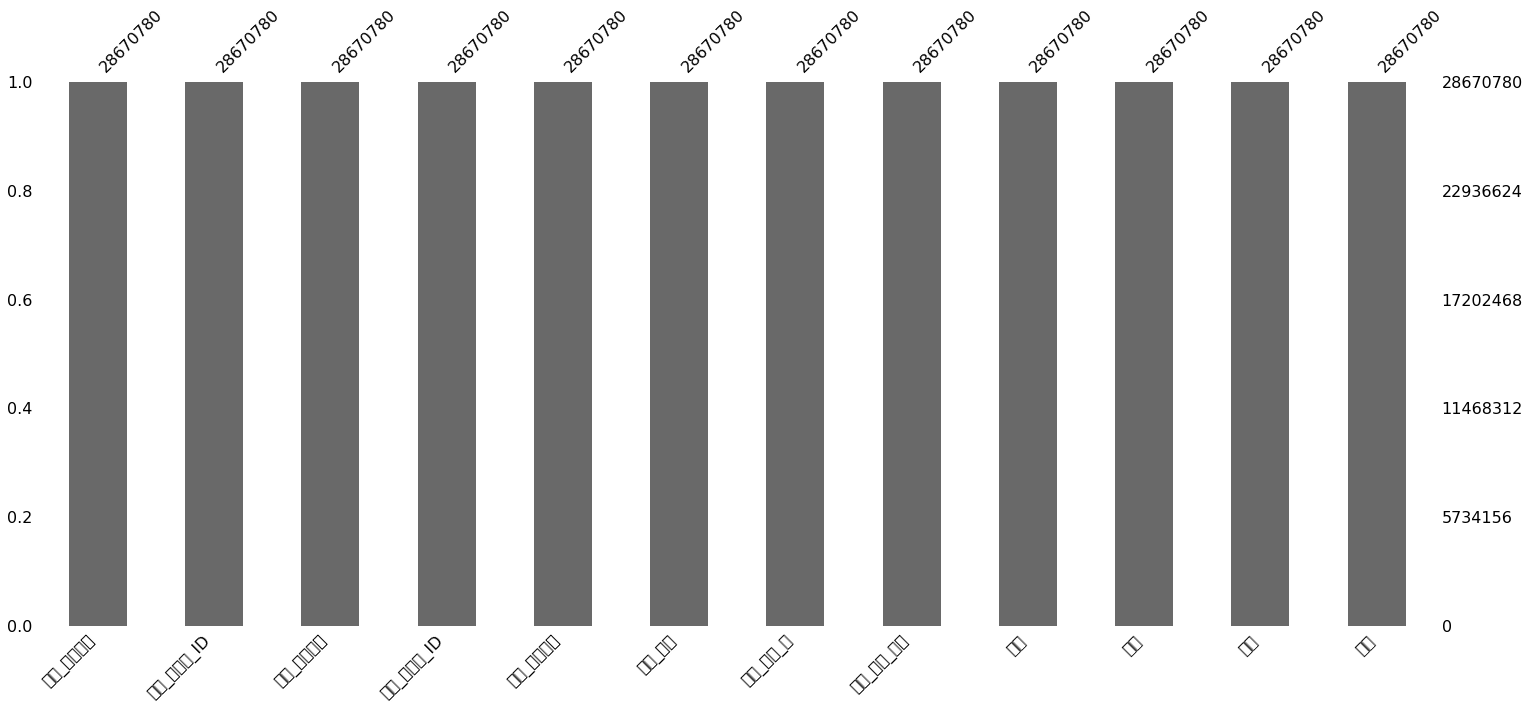

In [21]:
import missingno as msno
import matplotlib.pyplot as plt

msno.bar(df=bicycle_weather)
plt.show()

In [23]:
# bicycle_weather.to_csv('./bicycle_weather.csv')
# # bicycle_weather.to_csv('./bicycle_weather_cp949.csv', encoding='cp949')

In [24]:
bicycle_weather.columns

Index(['기준_날짜시간', '시작_대여소_ID', '시작_대여소명', '종료_대여소_ID', '종료_대여소명', '전체_건수',
       '전체_이용_분', '전체_이용_거리', '요일', '강수', '기온', '풍속'],
      dtype='object')